In [116]:
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import numpy as np

In [117]:
from calc_pseudo import clean, basic_flops
B_TARGET_PANEL_WIDTH = 48

MAT_PATH = "./../../../example_mats_med/"
mat_paths = sum([[os.path.join(dir, file) for file in files] for dir, _, files in os.walk(MAT_PATH)], [])

mat_flops = {}

for mat_path in mat_paths:
    with open(mat_path) as f:
        test_mat = clean(np.loadtxt(f))
    FLOPS_PER_PANEL = basic_flops(test_mat, B_TARGET_PANEL_WIDTH)
    
    mat_flops[mat_path.split("./../../../")[1]] = FLOPS_PER_PANEL

## Load Data

In [118]:
LOG_DIR = "./../../../logs/reg_pack/pyfr/"

with open(LOG_DIR+"run_1.dat", "rb") as f:
    run_1 = pickle.load(f)
with open(LOG_DIR+"run_2.dat", "rb") as f:
    run_2 = pickle.load(f)
with open(LOG_DIR+"run_3.dat", "rb") as f:
    run_3 = pickle.load(f)

## Get Data

In [119]:
shapes = ["quad", "hex", "tri", "tet"]
x_terms = ['a_unique', 'density']

In [120]:
def get_values(x_term, run, mat_flops, t='best'):
    NUM_PANELS = 192000 / 48

    local_best = []
    ref_best = []
    local_best_x, local_best_y = [], []
    ref_best_x, ref_best_y = [], []

    for shape in shapes:
        for i, u in enumerate(run[shape][x_term]):
            FLOPS_PER_PANEL = mat_flops[run[shape]['mat_file'][i]]

            time_per_panel_local = (run[shape]['xsmm_local_'+t][i]*1e-3)/NUM_PANELS
            time_per_panel_ref   = (run[shape]['xsmm_upstream_'+t][i]*1e-3)/NUM_PANELS

            local_best_x.append(u)
            local_best_y.append(FLOPS_PER_PANEL / time_per_panel_local)
            ref_best_x.append(u)
            ref_best_y.append(FLOPS_PER_PANEL / time_per_panel_ref)
    
    old_len = len(local_best_y)

    local_best_y = [x for _,x in sorted(zip(local_best_x,local_best_y))]
    local_best_x.sort()
    
    assert(old_len == len(local_best_y))

    ref_best_y = [x for _,x in sorted(zip(ref_best_x,ref_best_y))]
    ref_best_x.sort()

    return local_best_x, local_best_y, ref_best_x, ref_best_y

# Scatter

In [123]:
# unique
x_term = "a_unique"
local_best_x1, local_best_y1, ref_best_x1, ref_best_y1 = \
    get_values(x_term, run_1, mat_flops, 'best')
local_best_x2, local_best_y2, ref_best_x2, ref_best_y2 = \
    get_values(x_term, run_2, mat_flops, 'best')
local_best_x3, local_best_y3, ref_best_x3, ref_best_y3 = \
    get_values(x_term, run_3, mat_flops, 'best')
local_best_y_avg_unique = [sum(elem)/len(elem) for elem in zip(local_best_y1, local_best_y2, local_best_y3)]
ref_best_y_avg_unique = [sum(elem)/len(elem) for elem in zip(ref_best_y1, ref_best_y2, ref_best_y3)]
local_best_x_unique = local_best_x1
ref_best_x_unique = ref_best_x1

# density
x_term = "density"
local_best_x1, local_best_y1, ref_best_x1, ref_best_y1 = \
    get_values(x_term, run_1, mat_flops, 'best')
local_best_x2, local_best_y2, ref_best_x2, ref_best_y2 = \
    get_values(x_term, run_2, mat_flops, 'best')
local_best_x3, local_best_y3, ref_best_x3, ref_best_y3 = \
    get_values(x_term, run_3, mat_flops, 'best')
local_best_y_avg_density = [sum(elem)/len(elem) for elem in zip(local_best_y1, local_best_y2, local_best_y3)]
ref_best_y_avg_density = [sum(elem)/len(elem) for elem in zip(ref_best_y1, ref_best_y2, ref_best_y3)]
local_best_x_density = local_best_x1
ref_best_x_density = ref_best_x1

## Process to get best from each

In [124]:
for i in range(len(local_best_y_avg_unique)):
    # local slower
    if local_best_y_avg_unique[i] < ref_best_y_avg_unique[i]:
        local_best_y_avg_unique[i] = 0
        local_best_x_unique[i] = 0

        local_best_x_density[i] = 0
    # ref slower
    else:
        ref_best_y_avg_unique[i] = 0
        ref_best_x_unique[i] = 0

        ref_best_x_density[i] = 0

local_best_y_avg_unique = list(filter(lambda a: a != 0, local_best_y_avg_unique))
local_best_x_unique = list(filter(lambda a: a != 0, local_best_x_unique))
ref_best_y_avg_unique = list(filter(lambda a: a != 0, ref_best_y_avg_unique))
ref_best_x_unique = list(filter(lambda a: a != 0, ref_best_x_unique))

local_best_x_density = list(filter(lambda a: a != 0, local_best_x_density))
ref_best_x_density = list(filter(lambda a: a != 0, ref_best_x_density))

# for i in range(len(local_best_y_avg_density)):
#     # local slower
#     if local_best_y_avg_density[i] < ref_best_y_avg_density[i]:
#         local_best_y_avg_density[i] = 0
#         local_best_x_density[i] = 0

#         local_best_x_unique[i] = 0
#     # ref slower
#     else:
#         ref_best_y_avg_density[i] = 0
#         ref_best_x_density[i] = 0

#         ref_best_x_unique[i] = 0

# local_best_y_avg_density = list(filter(lambda a: a != 0, local_best_y_avg_density))
# local_best_x_density = list(filter(lambda a: a != 0, local_best_x_density))
# ref_best_y_avg_density = list(filter(lambda a: a != 0, local_best_y_avg_density))
# ref_best_x_density = list(filter(lambda a: a != 0, ref_best_x_density))

# local_best_x_unique = list(filter(lambda a: a != 0, local_best_x_unique))
# ref_best_x_unique = list(filter(lambda a: a != 0, ref_best_x_unique))


In [114]:
len(ref_best_x_density)

39

## Scatter plot

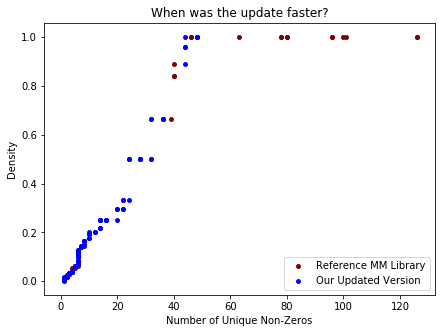

In [125]:
# plot best
plt.figure(figsize=(7,5))
#ax = fig.add_axes([0,0,1,1])

plt.scatter(ref_best_x_unique, ref_best_x_density, s=15, color='maroon', label="Reference MM Library")
plt.scatter(local_best_x_unique, local_best_x_density, s=15, color='b', label="Our Updated Version")


plt.xlabel('Number of Unique Non-Zeros')
plt.ylabel('Density')
plt.title('When was the update faster?')
plt.legend()
plt.savefig("./../../../plots/scatter/our_vs_red.pdf", dpi=fig.dpi)
plt.show()

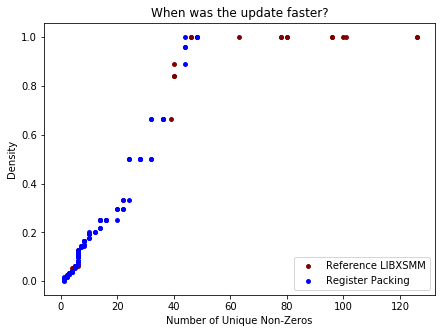

In [126]:
# plot best
plt.figure(figsize=(7,5))
#ax = fig.add_axes([0,0,1,1])

plt.scatter(ref_best_x_unique, ref_best_x_density, s=15, color='maroon', label="Reference LIBXSMM")
plt.scatter(local_best_x_unique, local_best_x_density, s=15, color='b', label="Register Packing")


plt.xlabel('Number of Unique Non-Zeros')
plt.ylabel('Density')
plt.title('When was the update faster?')
plt.legend(loc="lower right")
plt.savefig("./../../../plots/scatter/regpack.pdf", dpi=fig.dpi)
plt.show()